In [2]:
%load_ext autoreload
%autoreload 2



In [17]:
import numpy as np
import pandas as pd
from simulator import LungCancerProgressionGenerator

# Generate datasets for both scenarios
generator = LungCancerProgressionGenerator(num_patients=100000, doubling_time=134)
df_without_test = generator.generate_dataset(use_blood_test=False)
df_with_test = generator.generate_dataset(use_blood_test=True)

# Function to calculate and print statistics
def print_statistics(df, scenario):
    print(f"\nStatistics for {scenario}:")
    
    # Distribution of cancer stages at diagnosis
    stage_at_diagnosis = df[df['months_since_diagnosis'] == 0]['target_state'].value_counts(normalize=True).to_dict()
    print("\nDistribution of cancer stages at diagnosis:")
    for stage, count in stage_at_diagnosis.items():
        print(f"Stage {stage}: {count * 100:.2f}%")
    
    # Percentage of late-stage diagnoses (Stage III and IV)
    late_stage = (stage_at_diagnosis.get(3, 0) + stage_at_diagnosis.get(4, 0))
    print(f"\nPercentage of late-stage diagnoses (Stage III and IV): {late_stage * 100:.2f}%")
    
    # 1-year survival rate
    total_patients = df['sample_id'].nunique()
    patients_1year = df.groupby('sample_id').filter(lambda x: x['months_since_diagnosis'].max() > 12)
    survival_rate_1year = patients_1year['sample_id'].count() / total_patients
    # print(survival_rate_1year)
    print(f"\n1-year survival rate: {survival_rate_1year:.2f}")
    
    # Average age at diagnosis
    avg_age_at_diagnosis = df.groupby('sample_id')['age_at_diagnosis'].first().mean()
    print(f"\nAverage age at diagnosis: {avg_age_at_diagnosis:.2f} years")

    # # Average time spent in each state
    # state_durations = df.groupby('sample_id').apply(lambda x: x.groupby('origin_state')['time_transition_to_target'].diff().mean())
    # print("\nAverage time spent in each state (months):")
    # for state, duration in state_durations.mean().items():
    #     if state != 0 and not np.isnan(duration):  # Exclude Healthy state and NaN values
    #         print(f"State {state}: {duration:.2f}")

# Print statistics for both scenarios
print_statistics(df_without_test, "Without Blood Test")
print_statistics(df_with_test, "With Perfect Biennial Blood Test")

# Save the datasets to CSV files
df_without_test.to_csv('lung_cancer_data_15years_without_blood_test_accurate.csv', index=False)
df_with_test.to_csv('lung_cancer_data_15years_with_perfect_biennial_blood_test.csv', index=False)
print("\nData saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'")


Statistics for Without Blood Test:

Distribution of cancer stages at diagnosis:
Stage 1: 40.07%
Stage 3: 29.86%
Stage 2: 23.14%
Stage 4: 6.94%

Percentage of late-stage diagnoses (Stage III and IV): 36.79%

1-year survival rate: 24.92

Average age at diagnosis: 69.53 years

Statistics for With Perfect Biennial Blood Test:

Distribution of cancer stages at diagnosis:
Stage 1: 100.00%

Percentage of late-stage diagnoses (Stage III and IV): 0.00%

1-year survival rate: 32.18

Average age at diagnosis: 68.80 years

Data saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'


In [4]:
print(generator.get_monthly_death_probability(1))
print(generator.get_monthly_death_probability(2))
print(generator.get_monthly_death_probability(3))
print(generator.get_monthly_death_probability(4))

0.007154002685681893
0.01515549399745375
0.03112402340674325
0.04870291331009746


In [5]:
# check numbers of deceased patients in df_with_test and df_without_test
print(df_with_test[df_with_test['target_state'] == 5]['sample_id'].nunique())
print(df_without_test[df_without_test['target_state'] == 5]['sample_id'].nunique())

1588
1824


In [6]:
df_without_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,13,0,1,-1,NaN,59,60
1,13,1,1,-1,NaN,60,61
2,13,1,1,-1,NaN,61,62
3,13,1,1,-1,NaN,62,63
4,13,1,1,-1,NaN,63,64
...,...,...,...,...,...,...,...
97869,99952,4,5,66,67.416667,155,156
97870,99988,0,1,-1,NaN,87,88
97871,99988,1,1,-1,NaN,88,89
97872,99988,1,1,-1,NaN,89,90


In [7]:
df_with_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,4,0,1,-1,NaN,64,65
1,4,1,1,-1,NaN,65,66
2,4,1,1,-1,NaN,66,67
3,4,1,1,-1,NaN,67,68
4,4,1,1,-1,NaN,68,69
...,...,...,...,...,...,...,...
109964,99988,3,3,28,73.0,172,173
109965,99988,3,3,29,73.0,173,174
109966,99988,3,3,30,73.0,174,175
109967,99988,3,4,31,73.0,175,176


Time: 0.0
State counts: target_state
1    722
3    538
2    417
4    125
Name: count, dtype: int64
Time: 1.0
State counts: target_state
1    712
3    515
2    411
4    121
5     36
6      4
Name: count, dtype: int64
Time: 2.0
State counts: target_state
1    697
3    502
2    400
4    118
5     26
6     10
Name: count, dtype: int64
Time: 3.0
State counts: target_state
1    684
3    484
2    396
4    112
5     31
6     15
Name: count, dtype: int64
Time: 4.0
State counts: target_state
1    670
3    464
2    385
4    107
5     30
6     20
Name: count, dtype: int64
Time: 5.0
State counts: target_state
1    653
3    446
2    376
4    101
6     30
5     23
Name: count, dtype: int64
Time: 6.0
State counts: target_state
1    639
3    438
2    363
4     97
6     38
5     22
Name: count, dtype: int64
Time: 7.0
State counts: target_state
1    630
4    503
2    350
6     43
5     36
Name: count, dtype: int64
Time: 8.0
State counts: target_state
1    619
4    476
2    337
6     47
5     33
Name: cou

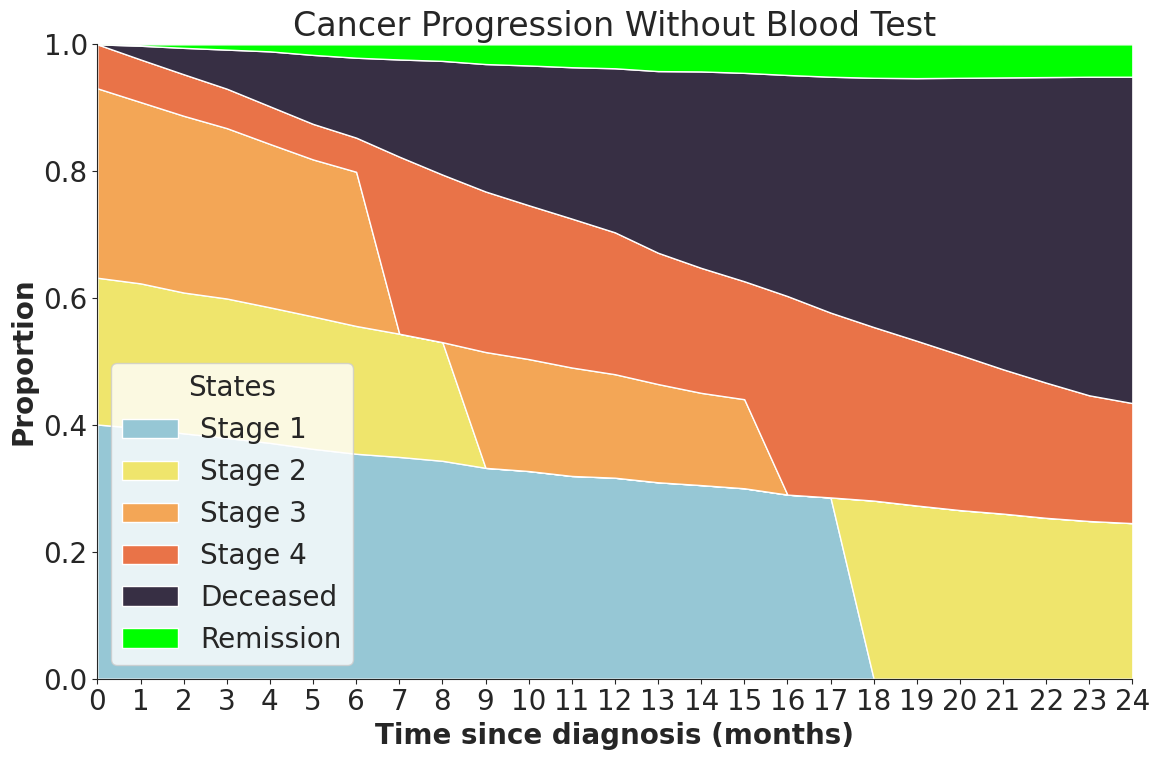

Time: 0.0
State counts: target_state
1    2338
Name: count, dtype: int64
Time: 1.0
State counts: target_state
1    2292
6      24
5      19
Name: count, dtype: int64
Time: 2.0
State counts: target_state
1    2256
6      41
5      15
Name: count, dtype: int64
Time: 3.0
State counts: target_state
1    2217
6      60
5      15
Name: count, dtype: int64
Time: 4.0
State counts: target_state
1    2174
6      80
5      18
Name: count, dtype: int64
Time: 5.0
State counts: target_state
1    2130
6      96
5      18
Name: count, dtype: int64
Time: 6.0
State counts: target_state
1    2088
6     118
5      11
2       5
Name: count, dtype: int64
Time: 7.0
State counts: target_state
1    1946
6     138
2     110
5      15
Name: count, dtype: int64
Time: 8.0
State counts: target_state
1    1820
2     203
6     157
5       9
Name: count, dtype: int64
Time: 9.0
State counts: target_state
1    1674
2     306
6     175
5      17
Name: count, dtype: int64
Time: 10.0
State counts: target_state
1    1515
2 

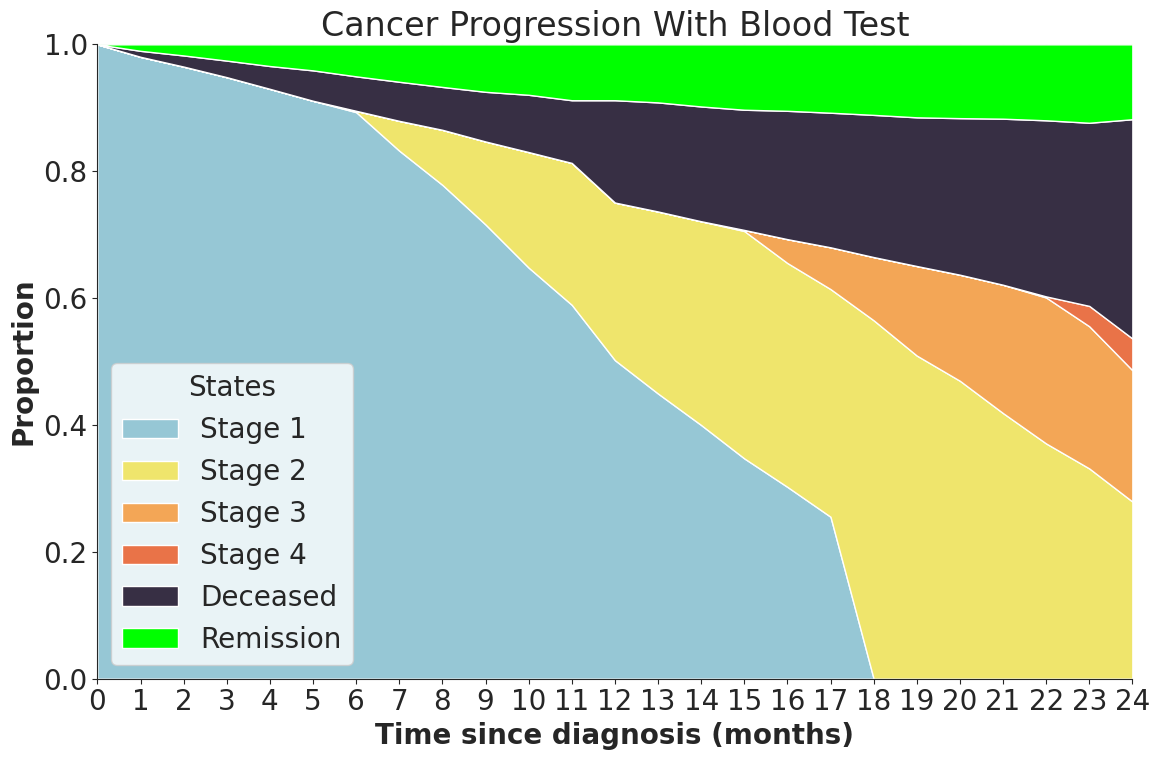

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data_prep import align_to_diagnosis
import seaborn as sns
sns.set_style('ticks')

def create_stacked_area_chart(df, title, save_path=None):
    # Align data to diagnosis point
    aligned_df = align_to_diagnosis(df)
    
    # Ensure all columns are numeric
    for col in aligned_df.columns:
        if aligned_df[col].dtype == 'object':
            aligned_df[col] = pd.to_numeric(aligned_df[col], errors='coerce')
    
    # Remove any rows with NaN values
    aligned_df = aligned_df.dropna()
    
    # Process the aligned data
    time_points = sorted(aligned_df['adjusted_time'].unique())
    states = sorted(aligned_df['target_state'].unique())
    
    initial_states_count = len(aligned_df[aligned_df['adjusted_time'] == 0]['target_state'])
    # Create a DataFrame to hold the proportions
    proportions = pd.DataFrame(index=time_points, columns=states)
    
    prev_censored = 0
    
    # Calculate proportions for each state at each time point
    for time in time_points:
        time_slice = aligned_df[aligned_df['adjusted_time'] == time]
        state_counts = time_slice['target_state'].value_counts()
        total = len(time_slice['sample_id'].unique())
        # for the difference between current total and initial total, fill with state 5 (death)
        diff = initial_states_count - total
        
        # check number of censored patients
        prev_censored = time_slice[time_slice['time_transition_to_target'] == 180]['sample_id'].nunique()
        
        if time < 25:
            print('Time:', time)
            print('State counts:', state_counts)
        
        if diff > 0:
            state_counts[5] = state_counts.get(5, 0) + diff
            # print('Adding', diff, 'deceased patients at time', time, 'for blood test = ', title)
        for state in states:
            proportions.loc[time, state] = state_counts.get(state, 0) / initial_states_count
            
    proportions.to_csv('proportions_temp.csv')
    
    proportions = pd.read_csv('proportions_temp.csv', header=None, index_col=0)
    
    # Create the stacked area plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # increase font size
    plt.rcParams.update({'font.size': 20})
    # make it bold 
    plt.rcParams['axes.labelweight'] = 'bold'
    
    
    # Custom color palette
    colors = ['#96C7D5', '#EFE56C', '#F3A656', '#E97348', '#372F44']

    
    colors = []#.reshape(5,3)
    #use hex color
    colors.append((150, 199, 213))
    colors.append((239, 229, 108))
    colors.append((243, 166, 86))
    colors.append((233, 115, 72))
    colors.append((55, 47, 68))
    # light green for remission
    colors.append((0, 255, 0))
    
    colors = np.array(colors) / 255
    
    # delete first row in proportions
    proportions = proportions.iloc[1:]
    
    month = 24
    month = month + 1
    # cut off at 5 years
    proportions = proportions.iloc[:month]
    
    # rename states
    states = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Deceased', 'Remission']
    
    ax.stackplot(proportions.index, proportions.T, labels=states, colors=colors)
    
    # Customize the plot
    ax.set_xlabel('Time since diagnosis (months)')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    # ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
    # put legend inside the plot on the bottom left
    ax.legend(title='States', loc='lower left')
    ax.set_xlim(0, month - 1)
    ax.set_ylim(0, 1)
    
    # set x ticks
    ax.set_xticks(np.arange(0, month, 1))
    # set x tick labels
    ax.set_xticklabels(np.arange(0, month, 1))
    # Add gridlines
    ax.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()
    return proportions, aligned_df

# Assuming df_without_test and df_with_test are your DataFrames
proportions_without, aligned_without = create_stacked_area_chart(df_without_test, "Cancer Progression Without Blood Test", save_path='figures/cancerProgressionWithoutBloodtest.pdf')
proportions_with, aligned_with = create_stacked_area_chart(df_with_test, "Cancer Progression With Blood Test", save_path='figures/cancerProgressionWithBloodtest.pdf')

In [19]:
# check patients who were diagnosed with stage 2
new_df = 

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time
27,30,2,3,0,70.250000,27,28,0.0
28,30,3,3,1,70.250000,28,29,1.0
29,30,3,3,2,70.250000,29,30,2.0
30,30,3,3,3,70.250000,30,31,3.0
31,30,3,3,4,70.250000,31,32,4.0
...,...,...,...,...,...,...,...,...
95181,99960,1,2,18,65.416667,155,156,18.0
95182,99960,2,2,19,65.416667,156,157,19.0
95183,99960,2,2,20,65.416667,157,158,20.0
95184,99960,2,2,21,65.416667,158,159,21.0


In [10]:
df_with_test.head()

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,4,0,1,-1,NaN,64,65
1,4,1,1,-1,NaN,65,66
2,4,1,1,-1,NaN,66,67
3,4,1,1,-1,NaN,67,68
4,4,1,1,-1,NaN,68,69


In [11]:
aligned_with

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time
8,4,1,1,0,70.0,72,73,0.0
9,4,1,1,1,70.0,73,74,1.0
10,4,1,1,2,70.0,74,75,2.0
11,4,1,1,3,70.0,75,76,3.0
12,4,1,1,4,70.0,76,77,4.0
...,...,...,...,...,...,...,...,...
109964,99988,3,3,28,73.0,172,173,28.0
109965,99988,3,3,29,73.0,173,174,29.0
109966,99988,3,3,30,73.0,174,175,30.0
109967,99988,3,4,31,73.0,175,176,31.0


In [12]:
aligned_without

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time
27,13,2,3,0,59.166667,86,87,0.0
28,13,3,3,1,59.166667,87,88,1.0
29,13,3,3,2,59.166667,88,89,2.0
30,13,3,3,3,59.166667,89,90,3.0
31,13,3,3,4,59.166667,90,91,4.0
...,...,...,...,...,...,...,...,...
97865,99952,4,4,62,67.416667,151,152,62.0
97866,99952,4,4,63,67.416667,152,153,63.0
97867,99952,4,4,64,67.416667,153,154,64.0
97868,99952,4,4,65,67.416667,154,155,65.0


In [13]:
# plot 2 year Overall survival with and without blood test using lifelines with number at risk and confidence interval
# using aligned_with and aligned_without

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def plot_survival_curves(aligned_df_with, aligned_df_without):
    # filter for only deceased patients
    # aligned_df_with = aligned_df_with[aligned_df_with['target_state'] == 5]
    # aligned_df_without = aligned_df_without[aligned_df_without['target_state'] == 5]
    
    # filter for only 1 years and more than -1
    aligned_df_with = aligned_df_with[aligned_df_with['months_since_diagnosis'] <= 12] 
    aligned_df_without = aligned_df_without[aligned_df_without['months_since_diagnosis'] <= 12]
    
    # keep one row per patient, with the last state
    aligned_df_with = aligned_df_with.sort_values('months_since_diagnosis').groupby('sample_id').tail(1)
    aligned_df_without = aligned_df_without.sort_values('months_since_diagnosis').groupby('sample_id').tail(1)
    
    
    # Create a KaplanMeierFitter object
    kmf_with = KaplanMeierFitter()
    kmf_without = KaplanMeierFitter()

    # Fit the data to the model
    kmf_with.fit(durations=aligned_df_with['months_since_diagnosis'], event_observed=aligned_df_with['target_state'] == 5, label='With Blood Test')
    kmf_without.fit(durations=aligned_df_without['months_since_diagnosis'], event_observed=aligned_df_without['target_state'] == 5, label='Without Blood Test')
    
    # Add 2 year OS rate with confidence interval in legend
    two_year_os_with = kmf_with.survival_function_at_times([12]).values[0]
    two_year_os_without = kmf_without.survival_function_at_times([12]).values[0]
    
    # get confidence interval
    # print(kmf_without.survival_function_at_times([12]))
    print(kmf_with.confidence_interval_survival_function_.iloc[12]['With Blood Test_lower_0.95'])
    print(kmf_with.confidence_interval_survival_function_.iloc[12]['With Blood Test_upper_0.95'])
    with_upper = kmf_with.confidence_interval_survival_function_.iloc[12]['With Blood Test_upper_0.95']
    with_lower = kmf_with.confidence_interval_survival_function_.iloc[12]['With Blood Test_lower_0.95']
    # print(kmf_without.survival_function_at_times([12]))
    print(kmf_without.confidence_interval_survival_function_.iloc[12]['Without Blood Test_lower_0.95'])
    print(kmf_without.confidence_interval_survival_function_.iloc[12]['Without Blood Test_upper_0.95'])
    without_upper = kmf_without.confidence_interval_survival_function_.iloc[12]['Without Blood Test_upper_0.95']
    without_lower = kmf_without.confidence_interval_survival_function_.iloc[12]['Without Blood Test_lower_0.95']
    # ci_with = kmf_with.confidence_interval_survival_function_at_times([12])
    # ci_without = kmf_without.confidence_interval_survival_function_at_times([12])
    

    # Create a plot
    fig, ax = plt.subplots(figsize=(14, 10))
    kmf_with.plot(ax=ax, label='With Blood Test (1-year OS: {:.2f} [{:.2f} - {:.2f}])'.format(two_year_os_with, with_lower, with_upper))
    kmf_without.plot(ax=ax, label='Without Blood Test (1-year OS: {:.2f} [{:.2f} - {:.2f}])'.format(two_year_os_without, without_lower, without_upper))
    add_at_risk_counts(kmf_with, kmf_without, ax=ax)
    ax.set_title('Overall Survival with and without Blood Test')
    ax.set_xlabel('Months since diagnosis')
    ax.set_ylabel('Survival probability')
    
    
    # Perform log-rank test
    results = logrank_test(aligned_df_with['months_since_diagnosis'], aligned_df_without['months_since_diagnosis'], event_observed_A=aligned_df_with['target_state'] == 5, event_observed_B=aligned_df_without['target_state'] == 5)
    print(f"\nLog-rank test p-value: {results.p_value}")
    
    
    print(f"\n1-year OS with blood test: {two_year_os_with:.2f}")
    print(f"1-year OS without blood test: {two_year_os_without:.2f}")
    
    # modify labels 
    # plt.legend(['With Blood Test', 'Without Blood Test'])
    # plt.legend(['With Blood Test (2-year OS: {:.2f})'.format(two_year_os_with), 'Without Blood Test (2-year OS: {:.2f})'.format(two_year_os_without)])
    # Add p value to legend
    
    # ax.legend(['With Blood Test (1-year OS: {:.2f})'.format(two_year_os_with), 'Without Blood Test (1-year OS: {:.2f})'.format(two_year_os_without)])
    ax.plot([], [], ' ', label=f'p-value: {results.p_value:.2f}')
    
    plt.tight_layout()
    
    plt.savefig('figures/overallSurvivalWithAndWithoutBloodTest.pdf', dpi=600)
    
    # ax.legend(title='Blood Test')
    
    plt.show()

    # Print median survival times
    median_survival_with = median_survival_times(kmf_with)
    median_survival_without = median_survival_times(kmf_without)
    print(f"Median survival time with blood test: {median_survival_with:.2f} months")
    print(f"Median survival time without blood test: {median_survival_without:.2f} months")

    
    
    
    
    

0.9072485960459189
0.9301199420557972
0.7525344439996448
0.7924362099904266

Log-rank test p-value: 1.1802330740085084e-37

1-year OS with blood test: 0.92
1-year OS without blood test: 0.77


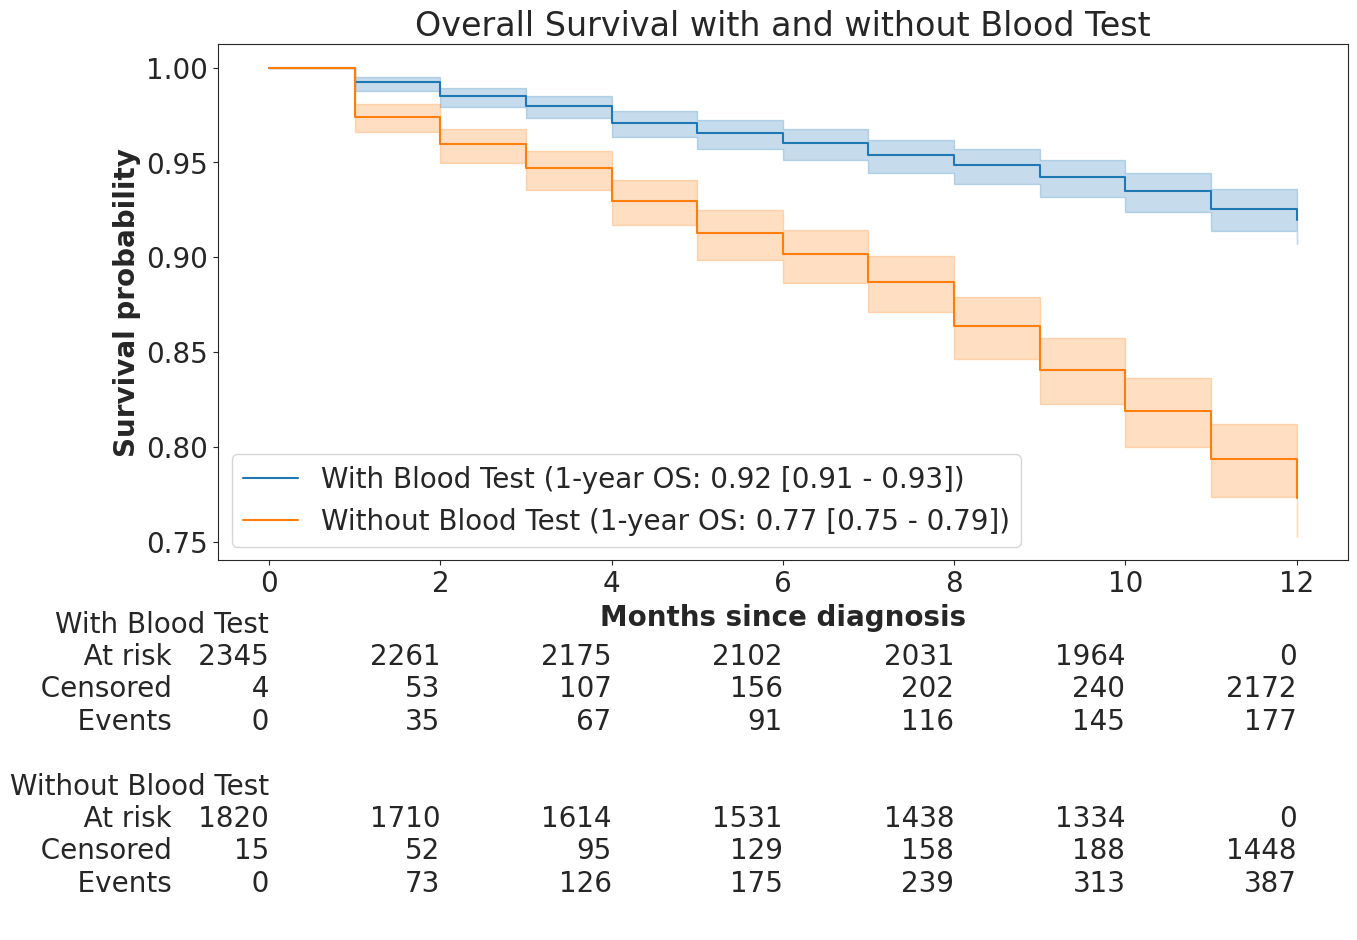

Median survival time with blood test: inf months
Median survival time without blood test: inf months


In [14]:
plot_survival_curves(aligned_with, aligned_without)

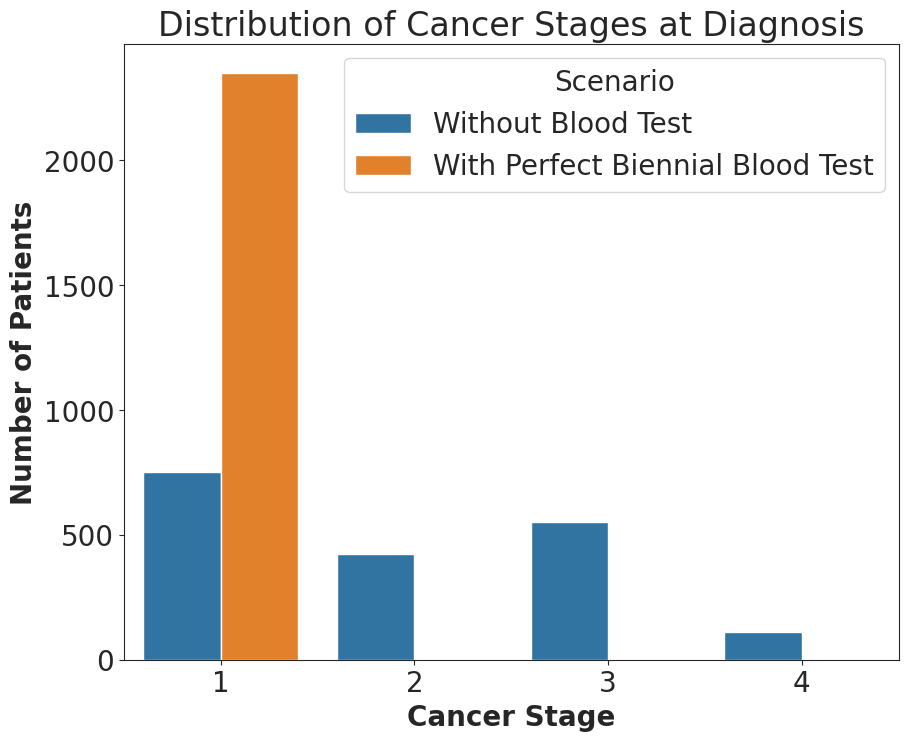

In [15]:
# Plot distribution of cancer stages at diagnosis
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the two datasets
df_without_test['scenario'] = 'Without Blood Test'
df_with_test['scenario'] = 'With Perfect Biennial Blood Test'
combined_df = pd.concat([df_without_test, df_with_test])

# Plot the distribution of cancer stages at diagnosis
plt.figure(figsize=(10, 8))
sns.countplot(data=combined_df[combined_df['months_since_diagnosis'] == 0], x='target_state', hue='scenario')
plt.title('Distribution of Cancer Stages at Diagnosis')
plt.xlabel('Cancer Stage')
plt.ylabel('Number of Patients')
plt.legend(title='Scenario')
plt.show()
